<a href="https://colab.research.google.com/github/buisonanh/LSTM-stock-prediction-model/blob/main/LSTM-stock-prediction-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.4 MB/s eta 0:00:00


In [2]:
from vnstock import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from pandas_datareader import data


# **Getting Data using 'vnstock' Library**

In [3]:
df = stock_historical_data(symbol="FPT", type="stock", start_date="2006-12-13", end_date="2023-09-22")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2875 non-null   object
 1   open    2875 non-null   int64 
 2   high    2875 non-null   int64 
 3   low     2875 non-null   int64 
 4   close   2875 non-null   int64 
 5   volume  2875 non-null   int64 
 6   ticker  2875 non-null   object
dtypes: int64(5), object(2)
memory usage: 157.4+ KB


In [5]:
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.date

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2875 non-null   object
 1   open    2875 non-null   int64 
 2   high    2875 non-null   int64 
 3   low     2875 non-null   int64 
 4   close   2875 non-null   int64 
 5   volume  2875 non-null   int64 
 6   ticker  2875 non-null   object
dtypes: int64(5), object(2)
memory usage: 157.4+ KB


# **Data Exploration**

In [7]:
df = df.sort_values('time', ascending=True)
df.head()

,time,open,high,low,close,volume,ticker
0,2012-03-20,6950,6950,6900,6900,94310,FPT
1,2012-03-21,6900,6950,6840,6900,145260,FPT
2,2012-03-22,6900,6900,6780,6780,90050,FPT
3,2012-03-23,6840,6840,6780,6840,71320,FPT
4,2012-03-26,6840,6840,6780,6840,112360,FPT


# **Data Visualization**

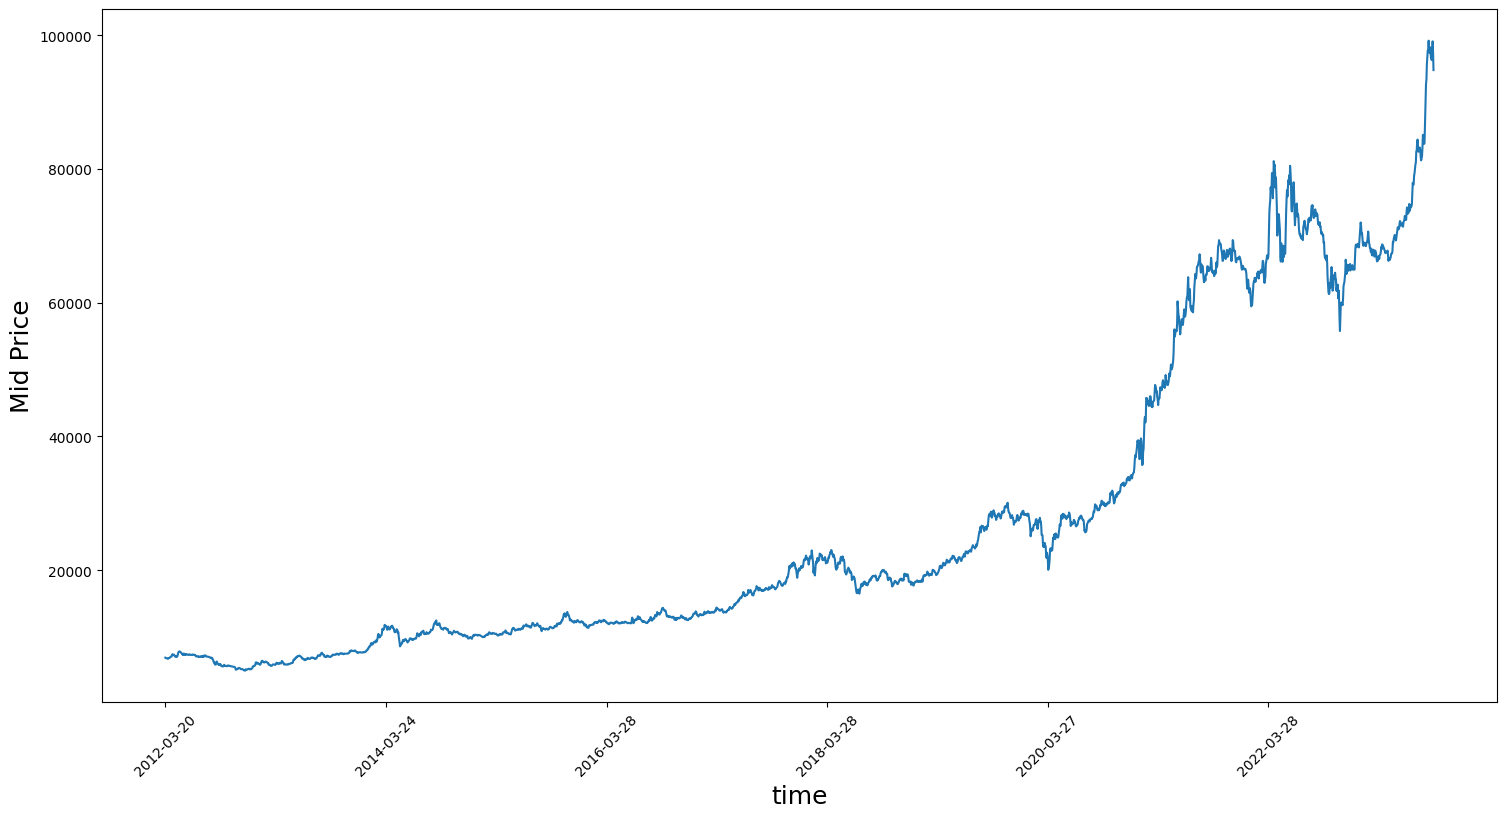

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['time'].loc[::500],rotation=45)
plt.xlabel('time',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# **Split Data into Traning and Test set**

In [9]:
high_prices = df.loc[:, 'high'].values
low_prices = df.loc[:, 'high'].values
mid_prices = (high_prices + low_prices) / 2

In [10]:
mid_prices.size

2875

In [11]:
train_set_length = int((mid_prices.size * 90)/100)

train_data = mid_prices[:train_set_length]
test_data = mid_prices[train_set_length:]

In [12]:
train_data.size

2587

# **Normalizing Data**

In [13]:
train_data = train_data.reshape(train_data.size,1)
train_data

array([[ 6950.],
       [ 6950.],
       [ 6900.],
       ...,
       [71550.],
       [72060.],
       [71550.]])

In [14]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

scaled_train_data

array([[0.02504842],
       [0.02504842],
       [0.02440284],
       ...,
       [0.85913493],
       [0.86571982],
       [0.85913493]])

# **Create X_train and y_train Data Structures**

In [15]:
X_train = []
y_train = []
for i in range(60, 2586):
  X_train.append(scaled_train_data[i-60:i, 0])
  y_train.append(scaled_train_data[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [16]:
print(X_train.shape)
print(y_train.shape)

(2526, 60)
(2526,)


In [17]:
# Reshape data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(2526, 60, 1)

# **Using LSTM**

In [18]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [19]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

In [20]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
79/79 [==============================] - 32s 156ms/step - loss: 0.0082
Epoch 2/50
79/79 [==============================] - 11s 134ms/step - loss: 0.0019
Epoch 3/50
79/79 [==============================] - 11s 134ms/step - loss: 0.0015
Epoch 4/50
79/79 [==============================] - 10s 132ms/step - loss: 0.0018
Epoch 5/50
79/79 [==============================] - 10s 120ms/step - loss: 0.0017
Epoch 6/50
79/79 [==============================] - 11s 136ms/step - loss: 0.0014
Epoch 7/50
79/79 [==============================] - 11s 137ms/step - loss: 0.0012
Epoch 8/50
79/79 [==============================] - 11s 138ms/step - loss: 0.0014
Epoch 9/50
79/79 [==============================] - 13s 161ms/step - loss: 0.0011
Epoch 10/50
79/79 [==============================] - 10s 131ms/step - loss: 0.0012
Epoch 11/50
79/79 [==============================] - 10s 123ms/step - loss: 0.0011
Epoch 12/50
79/79 [==============================] - 11s 135ms/step - loss: 0.0012
Epoch 13/50
7

# **Testing**

In [21]:
actual_stock_price = test_data.reshape(test_data.size, 1)

In [22]:
inputs = mid_prices[len(mid_prices) - len(test_data) - 60:]

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, test_data.size):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [23]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 31ms/step


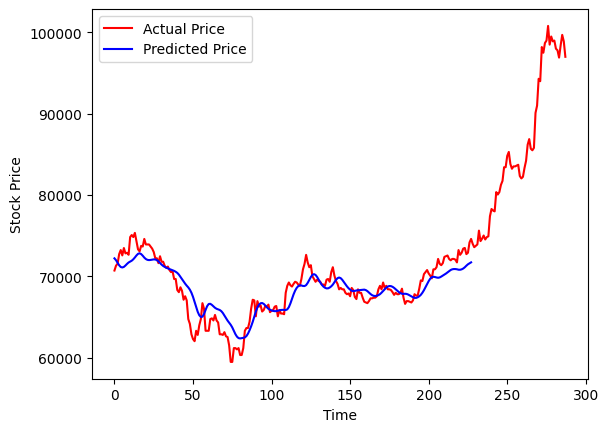

In [24]:
plt.plot(actual_stock_price, color='red', label='Actual Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()